In [8]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import matplotlib.pyplot as plt
import mlflow

In [9]:
from src.dataset import get_dataloaders
from src.model import LSTMModel, LinearWeightedMSELoss
from src.train import train_model
from src.metrics import evaluate_predictions
from src.predict import predict
from src.mlflow_logging import log_trained_model, log_true_and_predictions_values
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
PRED_LENGTH = 48
MODELS_BASENAME = "pytorch_model"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [11]:
train_dataloaders, val_dataloaders, scalers = get_dataloaders()

# Training

Custom errors implementation

In [12]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2 * PRED_LENGTH  # Predict Starts and Ends
NUM_LAYERS = 1

# Initialize the model
model = LSTMModel(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_SIZE, 
    future_feature_size=FUTURE_FEATURE_SIZE,
    output_size=OUTPUT_SIZE, 
    pred_length=PRED_LENGTH,
    num_layers=NUM_LAYERS
).to(DEVICE)

# Loss and optimizer
criterion = LinearWeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Training for Cluster 0
Epoch [1/10] - Train Loss: 0.0058, Train MAE: 0.0450, Val Loss: 0.0038, Val MAE: 0.0366
Epoch [2/10] - Train Loss: 0.0027, Train MAE: 0.0320, Val Loss: 0.0033, Val MAE: 0.0347
Epoch [3/10] - Train Loss: 0.0024, Train MAE: 0.0299, Val Loss: 0.0033, Val MAE: 0.0346
Epoch [4/10] - Train Loss: 0.0022, Train MAE: 0.0291, Val Loss: 0.0029, Val MAE: 0.0319
Epoch [5/10] - Train Loss: 0.0021, Train MAE: 0.0281, Val Loss: 0.0035, Val MAE: 0.0337
Epoch [6/10] - Train Loss: 0.0021, Train MAE: 0.0280, Val Loss: 0.0029, Val MAE: 0.0314
Epoch [7/10] - Train Loss: 0.0019, Train MAE: 0.0270, Val Loss: 0.0029, Val MAE: 0.0309
Epoch [8/10] - Train Loss: 0.0018, Train MAE: 0.0264, Val Loss: 0.0028, Val MAE: 0.0310
Epoch [9/10] - Train Loss: 0.0018, Train MAE: 0.0263, Val Loss: 0.0027, Val MAE: 0.0307
Epoch [10/10] - Train Loss: 0.0017, Train MAE: 0.0259, Val Loss: 0.0029, Val MAE: 0.0308


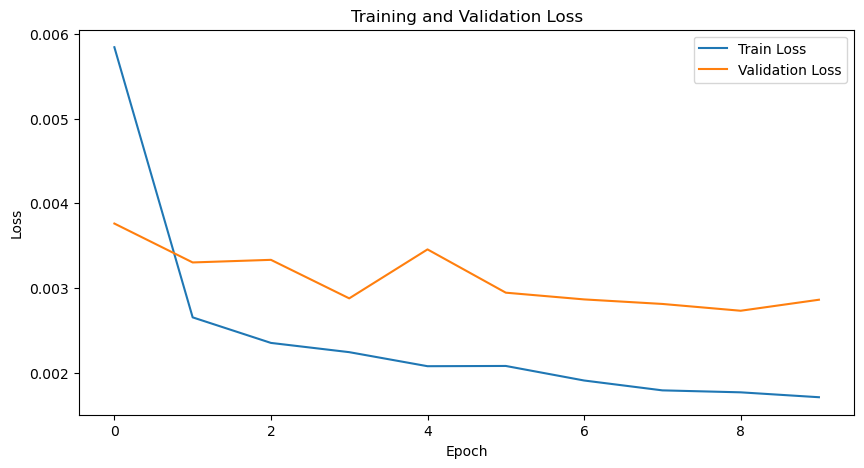

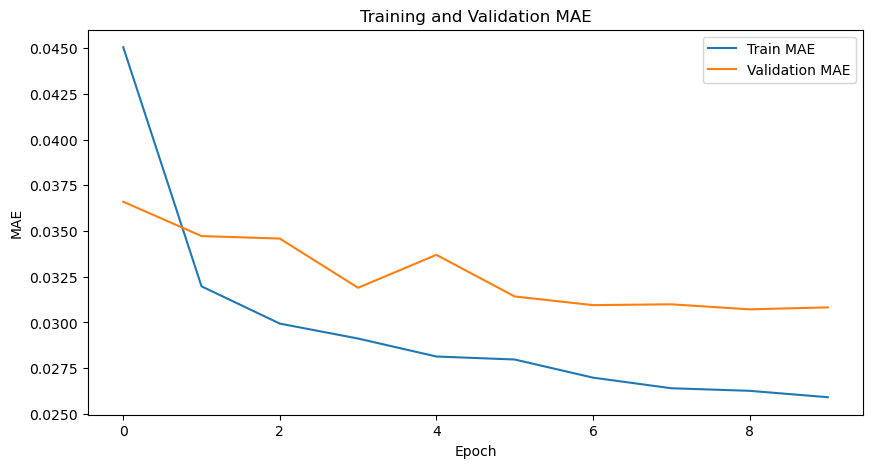

2025/04/05 21:10:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/05 21:10:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/05 21:10:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [13]:
cluster = 0
for train_dataloader, val_dataloader in zip(train_dataloaders.values(), val_dataloaders.values()):
    print(f'Training for Cluster {cluster}')
    mlflow.start_run()
    model = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=10)
    log_trained_model(model, MODELS_BASENAME + f"_{cluster}")

# Prediction

In [14]:
all_preds = {}
all_true = {}

for cluster in val_dataloaders.keys():
    print(f"Prediction for cluster: {cluster}")
    val_dataloader = val_dataloaders[cluster]
    scaler = scalers[cluster]
    all_preds[cluster], all_true[cluster], metadata = predict(model, val_dataloader, scaler)
    metrics = evaluate_predictions(all_true[cluster], all_preds[cluster], metadata)
    
    print(f"Overall Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")
    print(f"  sMAPE: {metrics['sMAPE']:.4f}%")

Prediction for cluster: 0
Overall Metrics:
  MAE: 9.9370
  RMSE: 15.8734
  R2: 0.9089
  sMAPE: 56.7906%


In [15]:
for pred, true in zip(all_preds.values(), all_true.values()):
    true_values_filename = "./data/results/true_values.npy"
    predictions_filename = "./data/results/predictions.npy"
    np.save(true_values_filename, pred)
    np.save(predictions_filename, true)    
    log_true_and_predictions_values(true_values_filename, predictions_filename)
mlflow.end_run()

In [16]:
original_scale_true = all_true[0]
original_scale_predictions = all_preds[0]

In [17]:
# Extract true and predicted values for Starts and Ends
true_starts = original_scale_true[:, :, 0]  # Shape: (batch_size, pred_length)
true_ends = original_scale_true[:, :, 1]    # Shape: (batch_size, pred_length)
pred_starts = original_scale_predictions[:, :, 0]  # Shape: (batch_size, pred_length)
pred_ends = original_scale_predictions[:, :, 1]    # Shape: (batch_size, pred_length)

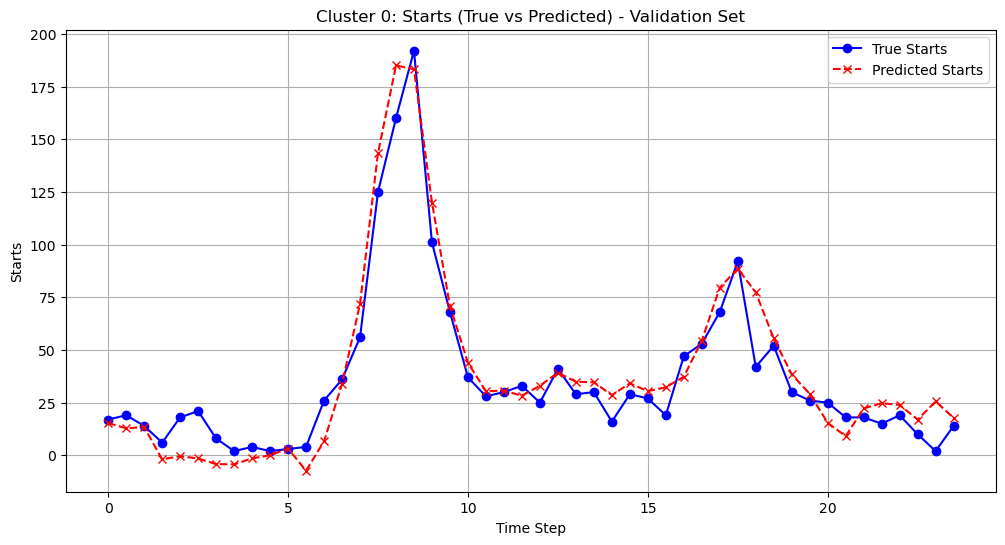

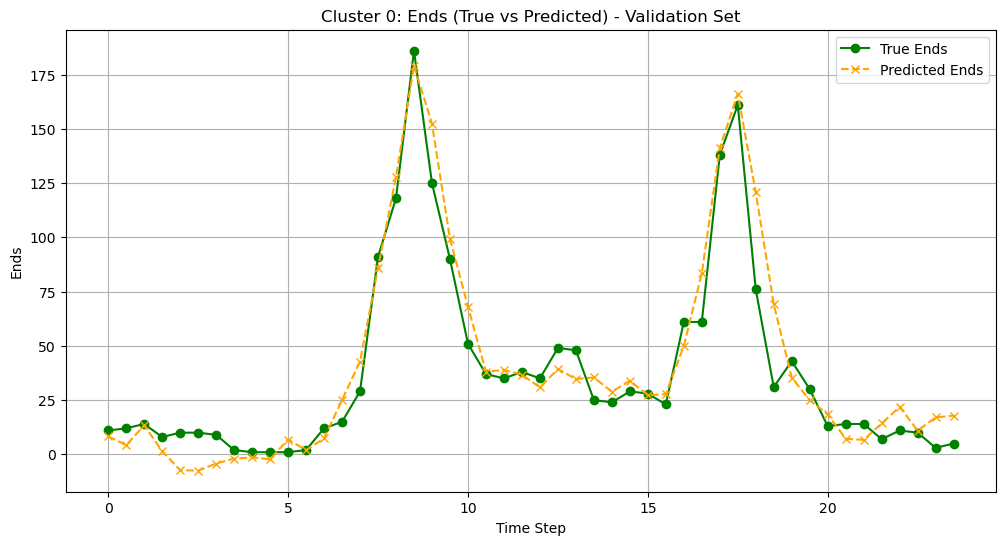

In [24]:
index = 48

# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_starts[index], label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_starts[index], label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_ends[index], label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_ends[index], label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()